So this is my first time on a keggle competition and me using pandas in a ML project altogether. Since I have had no clue where and how to start I went through https://www.kaggle.com/alexisbcook/titanic-tutorial. This provided me with a very basic set-up and had me run the RandomForestClassifier as my first ML model.
I started trying things out with it and realized that I can't easily use age since it has 177 NaNs. I thought of dropping these rows and read that this might not be a good idea. Then I read about the IterativeImputer which I tried.

## Import data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#### Import training and test data

In [2]:
train_data = pd.read_csv('titanic/train.csv')
test_data = pd.read_csv('titanic/test.csv')

## Analyse Data

In [3]:
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 1) Pclass

#### How many per class survived:

In [6]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


It seems like the passenger class is a strong indicator for survival. Since this is already an integer I am sure this can easily be used later when fitting the model.

### 2) Name

It might make sense to have family names and titles instead of a column of full names and titles all together and then drop the family name column completely.

In [7]:
train_data = train_data.assign(fname = train_data.Name.str.split(",").str[0])
train_data["title"] = pd.Series([i.split(",")[1].split(".")[0].strip() for i in train_data.Name], index=train_data.index)
train_data.drop("Name", axis=1, inplace=True)

And do the same for the test_data dataset.

In [8]:
test_data = test_data.assign(fname = test_data.Name.str.split(",").str[0])
test_data["title"] = pd.Series([i.split(",")[1].split(".")[0].strip() for i in test_data.Name], index=test_data.index)
test_data.drop("Name", axis=1, inplace=True)

In [9]:
test_data.fname.nunique(), test_data.title.nunique()

(352, 9)

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


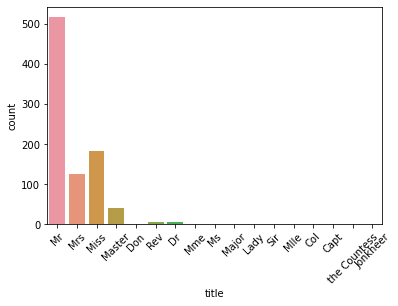

In [10]:
ts = sns.countplot(data=train_data, x="title")
ts = plt.setp(ts.get_xticklabels(), rotation=45)
print(train_data["title"].unique())
print(test_data["title"].unique())
other_titles = [title
                for title in train_data["title"]
                if title not in ["Mr", "Miss", "Mme", "Mlle", "Mrs", "Ms", "Master"]]

In [11]:
train_data["title"] = train_data['title'].replace(other_titles, 'Other')
train_data["title"] = train_data["title"].map({"Mr":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Master":2, "Other":3})
test_data["title"] = test_data['title'].replace(other_titles, 'Other')
test_data["title"] = test_data["title"].map({"Mr":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Master":2, "Other":3})

In [12]:
train_data.title.value_counts()

0    517
1    311
2     40
3     23
Name: title, dtype: int64

In [13]:
explore_title = train_data[['title', 'Survived']].groupby(['title'], as_index=False).mean().sort_values(by='Survived', ascending=False)
explore_title

,title,Survived
1,1,0.739550
2,2,0.575000
3,3,0.347826
0,0,0.156673


In [14]:
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder(handle_unknown="ignore", sparse = False)

survivors = [x for x in train_data[train_data["Survived"] == 1]["fname"]]
others = [x for x in train_data[train_data["Survived"] == 0]["fname"]]
train_data["fname"] = train_data['fname'].replace(survivors, 'survivor')
train_data["fname"] = train_data['fname'].replace(others, 'other')
train_data["fname"] = train_data["fname"].map({"survivor":1, "other":0})

other_test = [x for x in test_data["fname"] if x not in survivors]
test_data["fname"] = test_data['fname'].replace(survivors, 'survivor')
test_data["fname"] = test_data['fname'].replace(other_test, 'other_test')
test_data["fname"] = test_data["fname"].map({"survivor":1, "other_test":0})

train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fname,title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,1,1
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,1,1
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,1,0


### 3) Sex

In [15]:
train_data["Sex"] = train_data["Sex"].map({"female":0, "male":1})
test_data["Sex"] = test_data["Sex"].map({"female":0, "male":1})


#### Determine female survival rate

In [16]:
women = train_data.loc[train_data.Sex == 0]["Survived"]

rate_women = sum(women)/len(women)

print(f"The rate of women is: {rate_women}")

The rate of women is: 0.7420382165605095


#### Determine male survival rate

In [17]:
# train_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
men = train_data.loc[train_data.Sex == 1]["Survived"]
rate_men = sum(men)/len(men)

print(f"The rate of men is: {rate_men}")
men

The rate of men is: 0.18890814558058924


0      0
4      0
5      0
6      0
7      0
      ..
883    0
884    0
886    0
889    1
890    0
Name: Survived, Length: 577, dtype: int64

#### add one-hot encoded values from the embarked column

In [18]:
embarked_dummies = pd.get_dummies(train_data.Embarked, prefix='embarked')
train_data = pd.concat([train_data, embarked_dummies], axis=1)

embarked_dummies = pd.get_dummies(test_data.Embarked, prefix='embarked')
test_data = pd.concat([test_data, embarked_dummies], axis=1)
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fname,title,embarked_C,embarked_Q,embarked_S
0,892,3,1,34.5,0,0,330911,7.8292,NaN,Q,1,0.0,0,1,0
1,893,3,0,47.0,1,0,363272,7.0000,NaN,S,0,1.0,0,0,1
2,894,2,1,62.0,0,0,240276,9.6875,NaN,Q,0,0.0,0,1,0
3,895,3,1,27.0,0,0,315154,8.6625,NaN,S,0,0.0,0,0,1
4,896,3,0,22.0,1,1,3101298,12.2875,NaN,S,1,1.0,0,0,1


### 4) Age

Replace the missing data with the iterative imputer from scikit-learn.

In [19]:
# missing age data
missing_age_index = train_data['Age'].isna().index
missing_age_index

RangeIndex(start=0, stop=891, step=1)

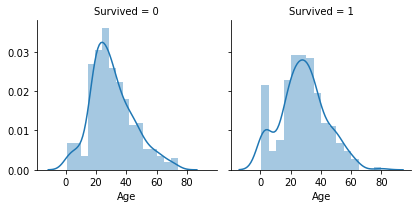

In [49]:
g = sns.FacetGrid(train_data, col='Survived')
g = g.map(sns.distplot, "Age")

### 5) & 6) SibSp & Parch

Sibling spouse and parent children respectively can be summarized to family size. I took this away from other notebooks as I was lost on this. It was summarized to family size (fsize).

In [50]:
train_data[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [51]:
train_data[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


To get the total size of the family from any one of the members you need 1 (from SibSp) + 2 (from Parch) + 1 (the passenger themself).

In [52]:
train_data["fsize"] = train_data["SibSp"] + train_data["Parch"] + 1
test_data["fsize"] = test_data["SibSp"] + test_data["Parch"] + 1

In [53]:
train_data[['fsize', 'Survived']].groupby(['fsize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,fsize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


### 7) Ticket

Tickets could be interesting as some have the same tickets and after looking at the first 20 tickets seem to give an indication towards survival rate where there is > 1 ticket. It could also make the model overfit so I'm dropping the column for now.

In [34]:
tickets = train_data.pivot_table(index=['Ticket', 'Survived'], aggfunc='size').sort_values(ascending=False)
tickets.head(20)

Ticket        Survived
CA. 2343      0           7
347082        0           7
3101295       0           6
CA 2144       0           6
347088        0           6
1601          1           5
S.O.C. 14879  0           5
382652        0           5
W./C. 6608    0           4
2666          1           4
113760        1           4
349909        0           4
4133          0           4
PC 17757      1           3
24160         1           3
LINE          0           3
13502         1           3
17421         1           3
110152        1           3
PC 17755      1           3
dtype: int64

In [46]:
train_data.loc[train_data.Ticket == "113760"]


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fname,title,embarked_C,embarked_Q,embarked_S
390,391,1,1,1,36.0,1,2,113760,120.0,B96 B98,S,1,0,0,0,1
435,436,1,1,0,14.0,1,2,113760,120.0,B96 B98,S,1,1,0,0,1
763,764,1,1,0,36.0,1,2,113760,120.0,B96 B98,S,1,1,0,0,1
802,803,1,1,1,11.0,1,2,113760,120.0,B96 B98,S,1,2,0,0,1


In [ ]:
train_data.drop(["Ticket"], axis=1, inplace=True)
test_data.drop(["Ticket"], axis=1, inplace=True)

### 8) Fare

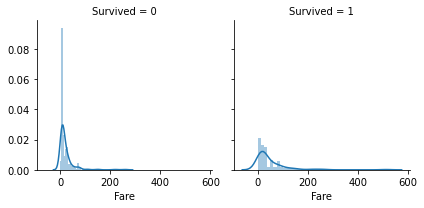

In [54]:
g = sns.FacetGrid(train_data, col='Survived')
g = g.map(sns.distplot, "Fare")

### 9) Cabin

In [ ]:
train_data.drop(["Cabin"], axis=1, inplace=True)
test_data.drop(["Cabin"], axis=1, inplace=True)

### 10) Embarked

In [ ]:
train_data["Embarked"] = train_data["Embarked"].map({"S":0, "Q":1, "C":2, "NaN": np.nan})
test_data["Embarked"] = test_data["Embarked"].map({"S":0, "Q":1, "C":2, "NaN": np.nan})

In [ ]:
train_data.head()

In [ ]:
y = train_data["Survived"]
train_data.drop("Survived", axis=1, inplace=True)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures


combined = pd.concat([train_data,test_data],keys=[0,1])

imp = IterativeImputer(max_iter = 20, random_state = 42)
combined = pd.DataFrame(imp.fit_transform(combined), index = combined.index, columns = combined.columns)

poly = PolynomialFeatures(degree=2)


train_data = combined.xs(0)
test_data = combined.xs(1)

train_data

In [ ]:
from sklearn.ensemble import RandomForestClassifier


features = ["Pclass", "Sex", "SibSp", "Parch", "embarked_C", "embarked_Q", "embarked_S", "Age", "Fare", "fname", "title", "embarked_C", "embarked_Q", "embarked_S"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId.astype('int'), 'Survived': predictions})
output.to_csv('result.csv', index=False)
output.head()